# Ultrasound Beamforming 

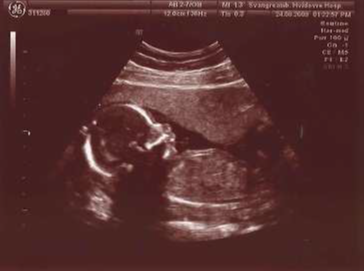

## Section 1: Setup

In [ ]:
import logging
logging.basicConfig(filename='python.log',
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger()

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp2d
import h5py
import pdb
import pandas as pd
from glob import glob
from scipy.fftpack import fft, fftshift
from numpy.linalg import inv, eig
from tqdm import tqdm
import numpy.matlib
import time


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Section 2: Help Function

### 2.1 Signal proccess functions


Time-gain compensation
The attenuation coefficient of tissue is usually expressed in dB and
defined as:

$$ alpha_{dB} = \frac{20}{x} * log_{10}(\frac{p(0)}{p(x)}) $$

where $x$ is the propagation
distance, $p(0)$ is the incident pressure, $p(x)$ is the spatially variant
pressure.  As a result:

$$ \frac{p(x)}{p(0)} = 10^{(-alphad_{dB}*\frac{x}{20})} $$


Additionally,
alpha is modeled as 

$$ alpha_{dB} = alpha_0 \cdot f^n $$

where f is frequency and $0 < n < 1$.
For tissue, $n ~ 1$. $alpha0$ is usually the parameter specified in
units of $dB/(MHz-cm)$. 
We can compensate therefore by multiplying each
A-line by 

$$ tgc_{gain} = 10^{(alpha_0 \cdot f \cdot \frac{x}{20} \cdot 100)} $$

Note that this does not take
into account the dissipation of acoustic energy with distance due to
non-plane wave propagation.

In [ ]:
def get_tgc(alpha0, prop_dist):
    """ 
    inputs:  alpha0 - attenutation coefficient in db/(MHz-cm)
             prop_dist - round-trip propagation distance of acoustic pulse in
                        meters
    outputs: tgc_gain - gain vector for multiplication with A-line """

    n = 1  # approx. 1 for soft tissue
    alpha = alpha0*(transmit_freq*1e-6)**n
    tgc_gain = 10**(alpha*prop_dist*100/20)

    return tgc_gain

Analog time-gain compensation is typically applied followed by an
anti-aliasing filter (low-pass) and then A/D conversion. The input data is
already digitized here, so no need for anti-alias filtering. Following A/D
conversion, one would ideally begin beamforming, however the summing
process in beamforming can produce very high values if low frequencies are
included. This can result in the generation of a dynamic range in the data
that exceeds what's allowable by the number of bits, thereby yielding data
loss. Therefore it's necessary to high-pass filter before beamforming
In addition, beamforming is more accurate with a higher sampling rate
because the calculated beamforming delays are more accurately achieved
Hence interpolation is used to upsample the signal. Finally, apodization
is applied before the beamformer.

This preprocessing function therefore consists of:

1.   Time-gain compensation.
2.   Anti-aliasing filter + A/D - not needed.
3.   Filtering.
4.   Interpolation.

In the filtering step I've appied a band-pass, as higher frequencies are
also problematic and are usually addressed after beamforming.

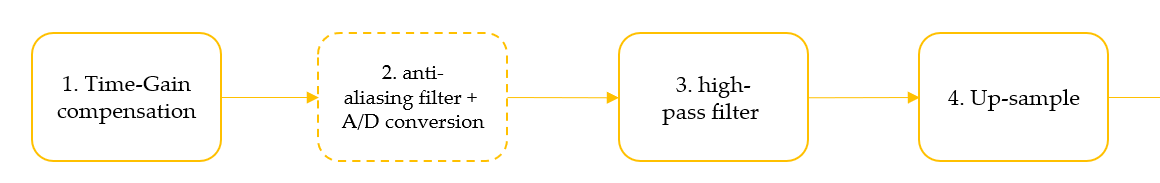

In [ ]:
def preproc(data, t, xd):
    """   
    inputs: data - transmission number x receive channel x time index
            t - time vector [s]
            xd - dector position vector [m]
    
    outputs: data_apod - processed data
             t2 - new time vectors
    """

    sample_rate = 1/(t[1] - t[0])
    record_length = data.shape[2]
    a0 = 0.4

    # get time-gain compensation vectors based on estimate for propagation
    # distance to each element
    zd = t*speed_sound/2
    zd2 = zd**2
    dist1 = zd
    tgc = np.zeros((n_probe_channels, record_length))
    for r in range(n_probe_channels):
        dist2 = np.sqrt(xd[r]**2 + zd2)
        prop_dist = dist1 + dist2
        tgc[r, :] = get_tgc(a0, prop_dist)

    # apply tgc
    data_amp = np.zeros(data.shape)
    print(data_amp.shape)
    for m in range(n_transmit_beams):
        data_amp[m, :, :] = data[m, :, :]*tgc

    # retrieve filter coefficients
    filt_ord = 201
    lc, hc = 0.5e6, 2.5e6
    lc = lc/(sample_rate/2)  # normalize to nyquist frequency
    hc = hc/(sample_rate/2)
    B = signal.firwin(filt_ord, [lc, hc], pass_zero=False)  # band-pass filter

    # specify interpolation factor
    interp_fact = 4
    sample_rate = sample_rate*interp_fact
    record_length2 = record_length*interp_fact

    # process
    data_apod = np.zeros((n_transmit_beams, n_probe_channels, record_length2))
    for m in range(n_transmit_beams):
        for n in range(n_probe_channels):
            w = data_amp[m, n, :]
            data_filt = signal.lfilter(B, 1, w) # filtering w through B
            # data_filt = w
            data_interp = signal.resample_poly(data_filt, interp_fact, 1) # upsample/interpolation
            data_apod[m, n, :] = data_interp

    # create new time vector based on interpolation and filter delay
    freqs, delay = signal.group_delay((B, 1)) # Compute the group delay of a digital filter B
    delay = int(delay[0]) * interp_fact
    t2 = np.arange(record_length2) / sample_rate + t[0] - delay / sample_rate

    # remove signal before t = 0
    f = np.where(t2 < 0)[0]
    t2 = np.delete(t2, f)
    data_apod = data_apod[:, :, f[-1]+1:]

    return data_apod, t2



### 2.2 Beamforming



#### 2.2.1 Presteering

The adaptive beamforming techniques were originally developed for radar
imaging systems. Thus, these methods have been developed for
far-field systems and they are primarily optimized for discrete point
targets. Consequently, when applying adaptive beamformers to ultrasound
imaging data, a number of problematic issues arise. The measured ultrasound
wave fields are near-field. In oredr to overcame the near-field problem we will use **Presteering**.
 
Steering the measured wave field at the point of interest will convert the nearfield wave into a semi-far-field wave. The steering
is carried out as the delay part of the conventional DAS beamformer. As the
steering is carried out prior to the summation and adaptation processes, it
will in the following be referred to as **presteering**.


Presteering at the point $ \hat r_p = (x_p,z_p) $
is carried out by compensating for
the propagation delay profile for this point. The delay is calculated as the
propagation path from the transmit element to the focus point and back to
the mth receiving element.

For a transducer array
of M elements, the delay is given by

$$ \tau_m(\hat r_p) = \frac{||\hat r^{Tx} - \hat r_p|| + ||\hat r^{Rx}_m - \hat r_p||}{c}   $$

for m = 0, 1, . . . ,M − 1, where c is the speed of sound, and $r^{Tx}$ and $\hat r^{Rx}_m$
m
are the spatial positions of the transmitting and mth receiving element, respectively.

By definition, the $\hat r_p$ is depend on the focus point.

When using PW, the propagation path from the transmitting element,
$\hat r^{Tx}$, to the current image point, $\hat r_p = (x_p, z_p)$, it simply becomes the axial distance, $z_p$, from the array to the image point

$$ ||\hat r^{TX} - \hat r_p|| = z_p $$



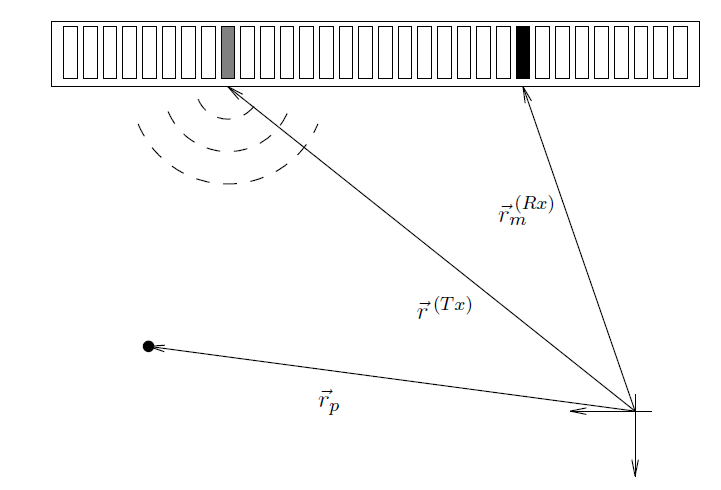

Ideally we could focus at all depths in receive when beamforming. This
is done in an FPGA by using time delays that are time-varying. To clarify,
suppose we use the above beamform function to focus at some depth z0. Why
not use the delay to achieve this focus merely for the value at that depth?
For some depth z0+dz, we would then have a new delay and use it to generate
the pixel only at z0+dz. So an array of time-dependent delay values can be
generated for each channel that would allow focusing at each depth.
In order to achieve dynamic focusing offline, digitally, one could find the
time-dependent delays and apply them, but this would require operating a
loop over each time value. One could also use the above beamform function
for each focal point and only keep the value generated for that depth, but
again this would computationally wasteful. An alternative is to fill the
a-line first with values corresponding to the propagation time from
emmission to pixel to receiver. One can then simply index the signal
received by an element at the estimtae for propagation time and add that
to the pixel, followed by summing contributions from other channels
Focusing at all depths is effectively acheived, and this is the method
applied below.

In [ ]:
def presteering(t):
  # We want to create a single beaformed a-line for each tranmission.
  # The lateral position of that a-line is aligned with the center of the
  # transmission. So, the following will get the acoustic propagation distance
  # starting at transmission, to a pixel above the center of the tranmission
  # and then to a receiver. This is done across all depths and receivers, which
  # can then be used to index the waveforms and perform the beamforming. 
  # These distances stay the same as we slide across the aperture of
  # the full array because they are relative to the center element.
  # So only a single 2d matrix is needed.
  sample_rate = 1 / (t[2] - t[1])
  zd = t * speed_sound / 2  # can be defined arbitrarily for higher resolution
  zd2 = zd**2
  prop_dist = np.zeros((n_probe_channels, len(zd)))
  for r in range(n_probe_channels):
      dist1 = zd
      dist2 = np.sqrt(xd[r]**2 + zd2)
      prop_dist[r, :] = dist1 + dist2

  # convert distance to sampling index
  prop_dist_ind = np.round(prop_dist / speed_sound * sample_rate)
  prop_dist_ind = prop_dist_ind.astype('int')

  # Eliminate out-of-bounds indices.
  # These indices can occur if the estimated propagation time to a peripheral
  # receiver is longer than the acquision time.
  # Replace these indices with last index of the waveform (likely to be of low signal 
  # at that location i.e closest to a null.
  oob_inds = np.where(prop_dist_ind >= len(t)) 
  prop_dist_ind[oob_inds[0], oob_inds[1]] = len(t) - 1

  return prop_dist_ind, zd

#### 2.2.2 DAS 

DAS beamformer maximize its output by delaying, weighting, and summing the sensor signals. Uses predefined apodization weights, which are independent of the input data. Compromise between the main-lobe width and the side-lobe level exists


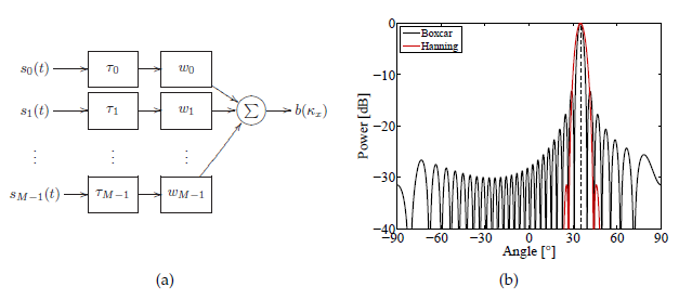

In [ ]:
def DAS(data, t, xd, window='tukey'):
    """
    inputs: {
            data: RF data (transmission number, receive channel, time index)
            t: time vector associated with RF waveforms, [t] = seconds
            xd: horizontal position vector of receive channels relative to
                 center, [xd] = meters
            
    outputs:
            image - beamformed data, dimensions of (scanline index, depth)
"""

    prop_dist_ind, zd = presteering(t)

    if window == 'tukey':
      apod_win = signal.tukey(n_probe_channels)
    elif window == 'boxcar':
      apod_win = signal.boxcar(n_probe_channels)
    elif window == 'hamming':
      apod_win = signal.hamming(n_probe_channels)


    # perform beamforming
    image = np.zeros((n_transmit_beams, len(zd)))
    for q in range(n_transmit_beams):  # index transmission (96 total)
        data_received = data[q, ...]
        scan_line = np.zeros(len(zd))
        for r in range(n_probe_channels):  # index receiver (32 total)
            v = data_received[r, :] * apod_win[r]
            scan_line = scan_line + v[prop_dist_ind[r, :]]
        image[q, :] = scan_line
    return image

#### 2.2.3 MVDR

Minimize the contributions from noise and interfering signals (Minimum Variance)

$$ 
\sigma^2 = E\{|b(k_x,t)|^2\} = E\{(w^Hy)^2\} = E\{w^Hy(w^Hy)^H\} = E\{w^Hyy^Hw\} = w^HE\{yy^H\}w = w^HR_yw
$$

It is seen that simply minimizing the variance will provide all-zero weights,
and thus a constraint must be introduced to the optimization problem. The
constraint in this case is that the signal from the steering direction should
be passed without distortion. Thus, the MV beamformer can be expressed
mathematically as

$$
\min _w w^HR_yw
$$
subject to $w^He=1$

where $e$ is steering vector

the closed-form solution to the optimization
problem is:

$$
w = \frac{R_y^{-1}e}{e^HR_y^{-1}e}
$$

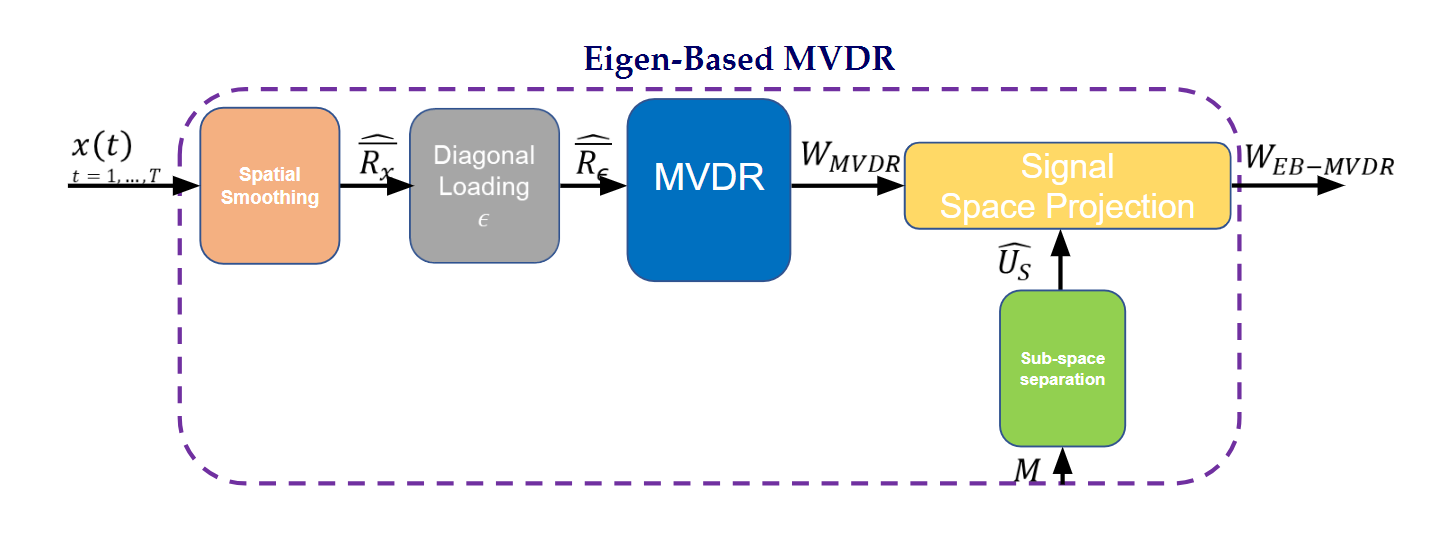

In [ ]:
def mvdr(data, t, xd, t_size, is_plot = 'False'):
    """
    inputs:  {
     data: - RF data (transmission number, receive channel, time index)
         t: 1-D time vector, [t] = seconds
         xd: horizontal position vector of receive channels relative to center,
             [xd] = meters
         receive_focus: depth of focus for beamforming,
             [receive_focus] = meters}
    outputs:  {
         image: beamformed data (scanline index, depth)}

    Presteering
    """
    start_time = time.time()
    prop_dist_ind, zd = presteering(t)

    waveform_length = data.shape[2]
    image = np.zeros((n_transmit_beams, waveform_length))  # initialize
    # apod_win = signal.tukey(n_probe_channels)
    L = 8
    P = n_probe_channels - L + 1
    apod_win = np.zeros((n_transmit_beams, L, waveform_length))
    

    image = np.zeros((n_transmit_beams, len(zd)))
    for q in tqdm(range(n_transmit_beams)):  # index transmission (96 total)
        for t in range(0, waveform_length, t_size):
          # input vector
          y = data[q, :, t:t+t_size]
          y = np.reshape(y,(-1,t_size))

          # Spatial Smoothing
          g = np.zeros((P,L,t_size))
          R_g = np.zeros((L,L))

          for p in range(0,P):
            g[p,:,:] = y[p:p+L,:]
            R_g += np.cov(g[p,:,:])
          R_g = R_g/P


          # Diagonal Loading
          eps = 0.001
          R_g += eps * np.trace(R_g) * np.identity(L)

          # weight calculation 
          a = np.ones(L)
          w = ( inv(R_g) @ a ) / ( np.conj(a).T @ inv(R_g) @ a )


          # Eigen-Decomposition
          eign_val, eig_vec = eig(R_g)
          # print(eign_val/np.max(eign_val)) 
          E_signal = eig_vec.T

          # Eigen-Based Minimum Variance weigths
          w_hat = E_signal @ np.conj(E_signal).T @ w
          w_hat_repmat = np.matlib.repmat(w_hat,t_size,1)
          apod_win[q,:,t:t+t_size] =  w_hat_repmat.T * (1/P) * np.sum(g, axis=0)
        
        data_received = data[q, ...]
        scan_line = np.zeros(len(zd))
        for r in range(L):  # index receiver (32 total)
            v = apod_win[q, r, :]
            scan_line = scan_line + v[prop_dist_ind[r, :]]
        image[q, :] = scan_line


    end_time = time.time()

    return image, apod_win, end_time-start_time

### 2.3 Image reconstruction helpers

In [ ]:
def arange2(start, stop=None, step=1):
    """
    #Modified version of numpy.arange which corrects error associated with non
    -integer step size
    """
    if stop is None:
        a = np.arange(start)
    else:
        a = np.arange(start, stop, step)
        if a[-1] > stop - step:
            a = np.delete(a, -1)
    return a


def envel_detect(scan_line, t, method='hilbert'):
    """Envelope detection. This can be done in a few ways:
    (1) Hilbert transform method
        - doesn't require knowledge of carrier frequency
        - simple - doesn't require filtering
        - cannot be implement with analog electronics
        - edge effects are undesirable
      
    (2) Demodulation + Low-pass filtering
        - implementable with analog electronics
        - requires knowledge of the carrier frequency, which gets smaller with
          propagation
        - more computational steps involved.
    'demod' and 'demod2' do exactly the same thing here. The former is merely
    the simplest/most intuitive way to look at the operation (multiplying by
    complex exponential yields a frequency shift in the fourier domain).
    Whereas with the latter, the I and Q components are defined, as is typical.
    """
    n = 201
    fs = 1/(t[1]-t[0])
    lc = 0.75e6
    b = signal.firwin(n, lc/(fs/2))  # low-pass filter

    if method == 'hilbert':
        envelope = np.abs(signal.hilbert(scan_line))
    elif method == 'demod':
        demodulated = scan_line*np.exp(-1j*2*np.pi*transmit_freq*t)
        demod_filt = np.sqrt(2)*signal.filtfilt(b, 1, demodulated)
        envelope = np.abs(demod_filt)
    elif method == 'demod2':
        I = scan_line*np.cos(2*np.pi*transmit_freq*t)
        If = np.sqrt(2)*signal.filtfilt(b, 1, I)
        Q = scan_line*np.sin(2*np.pi*transmit_freq*t)
        Qf = np.sqrt(2)*signal.filtfilt(b, 1, Q)
        envelope = np.sqrt(If**2+Qf**2)
    return envelope


def log_compress(data, dynamic_range, reject_level, bright_gain):
    """Dynamic range is defined as the max value of some data divided by the
    minimum value, and it is a measure of how spread out the data values are
    If the data values have been converted to d_b, then dynamic range is
    defined as the max value minus the minimum value.
    One could interpret there being two stages of compression in the standard
    log compression process. The first is the simple conversion to d_b. The
    second  is in selecting to display a certain range of d_b
    inputs:
            data - envelope-detected data having values >= 0. Dimensions should
                   be scanline x depth/time index
            dynamic_range - desired dynamic range of data to present [d_b]
            reject_level - level of rejection [d_b]
            bright_gain - brightness gain [d_b]
    output:
            xd_b3 - processed image, dimensions of scanline x depth/time index
    """

    # compress to dynamic range chosen
    xd_b = 20*np.log10(data+1)
    xd_b2 = xd_b - np.max(xd_b)  # shift such that max is 0 d_b
    xd_b3 = xd_b2 + dynamic_range  # shift such that max is dynamic_range value
    xd_b3[xd_b3 < 0] = 0  # eliminate data outside of dynamic range

    # rejection
    xd_b3[xd_b3 <= reject_level] = 0

    # add brightness gain, keep max value = dynamic_range
    xd_b3 = xd_b3 + bright_gain
    xd_b3[xd_b3 > dynamic_range] = dynamic_range
    
    return xd_b3


def scan_convert(data, xb, zb):
    """create 512x512 pixel image
    inputs: data - scanline x depth/time
            xb - horizontal distance vector
            zb - depth vector
    outputs: image_sC - scanline x depth/time
             znew - new depth vector
             xnew - new horizontal distance vector"""

    # decimate in depth dimensions
    decim_fact = 8
    data = data[:, 0:-1:decim_fact]
    zb = zb[0:-1:decim_fact]

    # interpolation
    interp_func = interp2d(zb, xb, data, kind='linear')
    dz = zb[1]-zb[0]
    xnew = arange2(xb[0], xb[-1]+dz, dz)  # make pixel square by making dx = dz
    znew = zb
    image_sC = interp_func(znew, xnew)

    return image_sC, znew, xnew


def plot(images_proc, x_sc, z_sc, titles):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    ax1.imshow(images_proc[0], extent=[x_sc[0]*1e3, x_sc[-1]*1e3,
                                       z_sc[-1]*1e3, z_sc[0]*1e3], cmap='gray',
               interpolation='none')
    ax1.set_ylabel('Depth(mm)')
    ax1.set_xlabel('x(mm)')
    # ax1.set_title('No beamforming')
    ax1.set_title(titles[0])

    ax2.imshow(images_proc[1], extent=[x_sc[0]*1e3, x_sc[-1]*1e3, z_sc[-1]*1e3,
                                       z_sc[0]*1e3], cmap='gray',
               interpolation='none')
    ax2.set_ylabel('Depth(mm)')
    ax2.set_xlabel('x(mm)')
    # ax2.set_title('DAS tukey window')
    ax2.set_title(titles[1])

    ax3.imshow(images_proc[2], extent=[x_sc[0]*1e3, x_sc[-1]*1e3, z_sc[-1]*1e3,
                                       z_sc[0]*1e3], cmap='gray',
               interpolation='none')
    ax3.set_ylabel('Depth(mm)')
    ax3.set_xlabel('x(mm)')
    # ax3.set_title('DAS boxcar window')
    ax3.set_title(titles[2])

    ax4.imshow(images_proc[3], extent=[x_sc[0]*1e3, x_sc[-1]*1e3, z_sc[-1]*1e3,
                                       z_sc[0]*1e3], cmap='gray',
               interpolation='none')
    ax4.set_ylabel('Depth(mm)')
    ax4.set_xlabel('x(mm)')
    # ax4.set_title('MVDR')
    ax4.set_title(titles[3])

    plt.tight_layout()
    fig.savefig('./result.png')
    plt.show()


## Section 3: Load Signal Data

To simulate bulk tissue contrast, three spherical regions with increased scattering and impedance are defined. The centers of the three spheres are co-aligned with center of the transducer in the elevation direction. A schematic of the simulation layout and a slice through the scattering phantom in the beam plane are shown below.



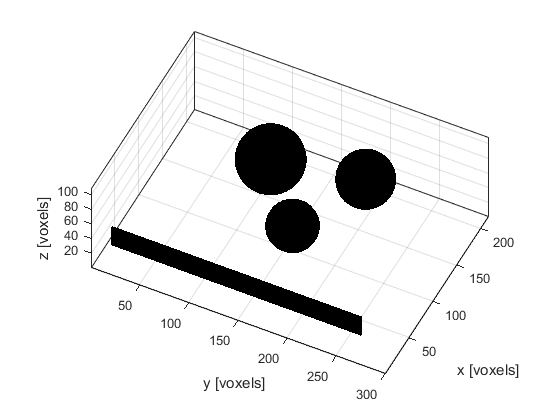

This example thaen from here:
[Simulating B-mode Ultrasound Images Example](http://www.k-wave.org/documentation/example_us_bmode_linear_transducer.php)

In [ ]:
base_path = '/content/gdrive/My Drive/Code/Python/ulrasound_beamforming/'
file_name = 'example_us_bmode_sensor_data.h5'
file_path = base_path + file_name
h5f = h5py.File(file_path)
sensor_data = h5f['dataset_1'][:]

# constants
n_transmit_beams = 96
n_probe_channels = 32
transmit_freq = 1.5e6
transmit_focal_depth = 20e-3
speed_sound = 1540
array_pitch = 2*1.8519e-4
sample_rate = 27.72e6
time_offset = 1.33e-6  # time at which middle of the transmission pulse occurs

## Section 4: Proccess signal

### 4.1 Pre-proccess:


applaying pre proceess to the recived signal before the beamforming step:


1.   time-gain compensation
2.   filtering
3.   interpolation
4.   apodization

In [ ]:
logger.info(f'Data shape = {sensor_data.shape}')
# data get info
record_length = sensor_data.shape[2]

# time vector for data
time = np.arange(record_length) / sample_rate - time_offset

# transducer locations relative to the a-line, which is always centered
xd = np.arange(n_probe_channels) * array_pitch
xd = xd - np.max(xd) / 2

# preprocessing - signal filtering, interpolation, and apodization
preproc_data, time_shifted = preproc(sensor_data, time, xd)

logger.info(f'Preproc Data shape = {preproc_data.shape}')
plot_steps = False
if plot_steps:
    aline_ind = 15
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(time, sensor_data[45, aline_ind, :])
    ax.plot(time_shifted, preproc_data[45, aline_ind, :])
    ax.set_ylim([-5000, 5000])
    fig.savefig('./preproc.png', dpi=150)

# B-mode image w/o beamforming (only use waveform from central element)
image = preproc_data[:, 15, :]

(96, 32, 1585)


### 4.2 Beamforming

Implemente defferent beamforming method to the recived signal:
1. DAS
2. MVDR

In [ ]:
import time
# DAS beamforming with dynamic focusing
image_df1 = DAS(preproc_data, time_shifted, xd, window='tukey')
image_df2 = DAS(preproc_data, time_shifted, xd, window='boxcar')

# MVDR beamforming with dynamic focusing
# t_size = 1
# t_size = 4
# t_size = 12
# t_size = 23
# t_size = 252
# t_size = 5796
time_mvdr = []
image_mvdr_4, _, proc_time = mvdr(preproc_data, time_shifted, xd, t_size=4, is_plot='False')
time_mvdr.append(proc_time)

image_mvdr_12, _, proc_time = mvdr(preproc_data, time_shifted, xd, t_size=23, is_plot='False')
time_mvdr.append(proc_time)

image_mvdr_23, apodwin, proc_time = mvdr(preproc_data, time_shifted, xd, t_size=252, is_plot='False')
time_mvdr.append(proc_time)

image_mvdr_252, _, proc_time = mvdr(preproc_data, time_shifted, xd, t_size=5796, is_plot='False')
time_mvdr.append(proc_time)


logger.info(f'Beamformed Data shape = {image_df1.shape}')
logger.info(f'Beamformed data su m = {np.sum(image_df1[0, :])}')

# images = (image, image_bf1, image_bf2, image_df)
images = (image, image_df1, image_df2, image_mvdr_23)
# images2 = (image_mvdr_4, image_mvdr_12, image_mvdr_23, image_mvdr_252)
z = time_shifted*speed_sound/2

# lateral locations of beamformed a-lines
xd2 = np.arange(n_transmit_beams) * array_pitch
xd2 = xd2 - np.max(xd2)/2

100%|██████████| 96/96 [00:01<00:00, 49.97it/s]


In [ ]:
time_mvdr

[336.86031007766724, 63.31135439872742, 7.39708685874939, 1.9035556316375732]

### 4.3 Image reconstruction

Reconstract the image from the signal by:
1. Detecte the envelop
2. Log compress the signal
3. Converting to 512x512 pixel image

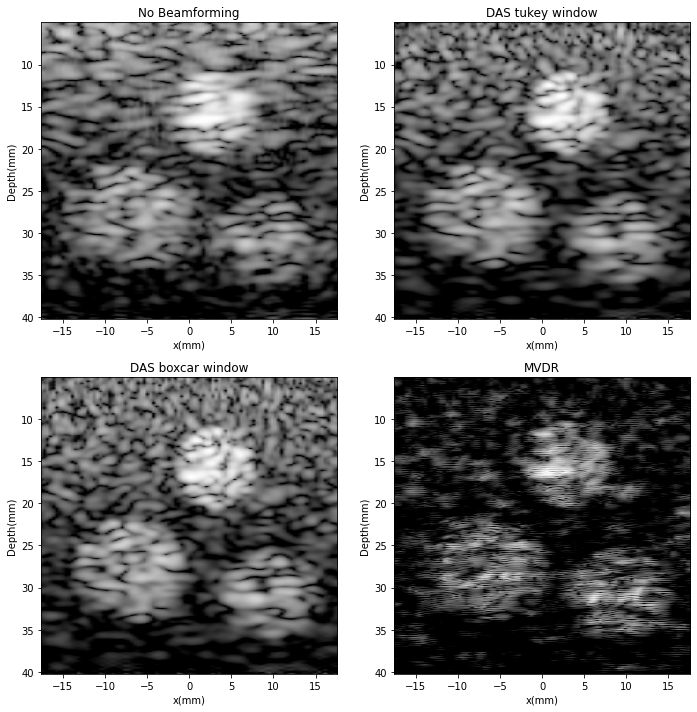

In [ ]:
# post process all images generated
images_proc = []
for n, im in enumerate(images):
    
    # define portion of image you want to display
    # includes nullifying beginning of image containing transmission pulse
    f = np.where(z < 5e-3)[0]
    z_trunc = np.delete(z, f)
    im_trunc = im[:, f[-1]+1:]

    # envelope detection
    im_trunc_orig = im_trunc.copy()
    for m in range(n_transmit_beams):
        im_trunc[m, :] = envel_detect(im_trunc[m, :], 2*z_trunc/speed_sound,
                                  method='hilbert')

    # log compression and scan conversion
    DR = 35   # dynamic range - units of dB
    reject = 0   # rejection level - units of dB
    BG = 0   # brightness gain - units of dB
    image_log = log_compress(im_trunc, DR, reject, BG)

    # convert to 512x512 image
    image_sc, z_sc, x_sc = scan_convert(image_log, xd2, z_trunc)

    if n == 3:
        if plot_steps:
            # plot some intermediate steps for the beamformed image
            # plot some intermediate steps          
            fig, ax = plt.subplots();
            ax.plot(im_trunc_orig[aline_ind, :]);
            ax.plot(im_trunc[aline_ind, :]);
            fig.savefig('./envelope.png')
            logger.info(f'Envelope detected Data shape = {im_trunc.shape}')

            fig, ax = plt.subplots(); 
            ax.plot(image_log[aline_ind, :])
            fig.savefig('./img_log_slice.png')
        logger.info(f'Scan converted Data shape = {image_sc.shape}')

    image_sc2 = np.round(255*image_sc/DR)  # convert to 8-bit grayscale
    image_sc3 = image_sc2.astype('int')
    images_proc.append(np.transpose(image_sc3))
titles = ['No Beamforming', 'DAS tukey window', 'DAS boxcar window', 'MVDR']
plot(images_proc, x_sc, z_sc, titles)

### 4.4 Processing time

MVDR algorithm calculate the beamformer weights for each input time sample. We can use the same weights for following time-samples by considering them as i.i.d samples that described the channle statiscits for the covariance matrix:

$$
R_y=E\{yy^H\}
$$

This will give us less weights to calculate, leading to less complex model. However, the image recunstraction will suffer from degregation

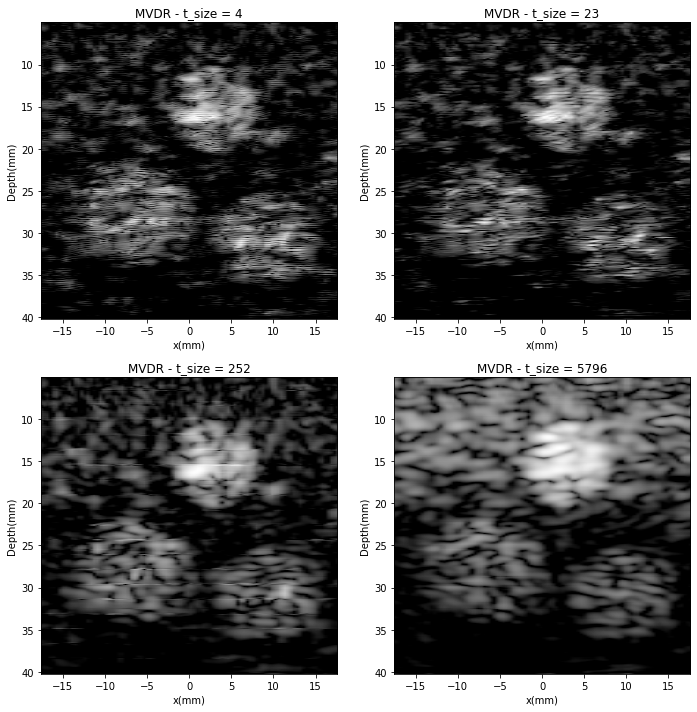

In [ ]:
images2 = (image_mvdr_4, image_mvdr_12, image_mvdr_23, image_mvdr_252)
images_proc = []
for n, im in enumerate(images2):
    
    # define portion of image you want to display
    # includes nullifying beginning of image containing transmission pulse
    f = np.where(z < 5e-3)[0]
    z_trunc = np.delete(z, f)
    im_trunc = im[:, f[-1]+1:]

    # envelope detection
    im_trunc_orig = im_trunc.copy()
    for m in range(n_transmit_beams):
        im_trunc[m, :] = envel_detect(im_trunc[m, :], 2*z_trunc/speed_sound,
                                  method='hilbert')

    # log compression and scan conversion
    DR = 35   # dynamic range - units of dB
    reject = 0   # rejection level - units of dB
    BG = 0   # brightness gain - units of dB
    image_log = log_compress(im_trunc, DR, reject, BG)

    # convert to 512x512 image
    image_sc, z_sc, x_sc = scan_convert(image_log, xd2, z_trunc)

    if n == 3:
        if plot_steps:
            # plot some intermediate steps for the beamformed image
            # plot some intermediate steps          
            fig, ax = plt.subplots();
            ax.plot(im_trunc_orig[aline_ind, :]);
            ax.plot(im_trunc[aline_ind, :]);
            fig.savefig('./envelope.png')
            logger.info(f'Envelope detected Data shape = {im_trunc.shape}')

            fig, ax = plt.subplots(); 
            ax.plot(image_log[aline_ind, :])
            fig.savefig('./img_log_slice.png')
        logger.info(f'Scan converted Data shape = {image_sc.shape}')

    image_sc2 = np.round(255*image_sc/DR)  # convert to 8-bit grayscale
    image_sc3 = image_sc2.astype('int')
    images_proc.append(np.transpose(image_sc3))
titles = ['MVDR - t_size = 4', 'MVDR - t_size = 23', 'MVDR - t_size = 252', 'MVDR - t_size = 5796']
plot(images_proc, x_sc, z_sc, titles)

In [ ]:
time_mvdr

[330.19198083877563, 61.4052574634552, 7.044604778289795, 1.805295705795288]

0
1
2
3


<function matplotlib.pyplot.show>

<Figure size 432x288 with 0 Axes>

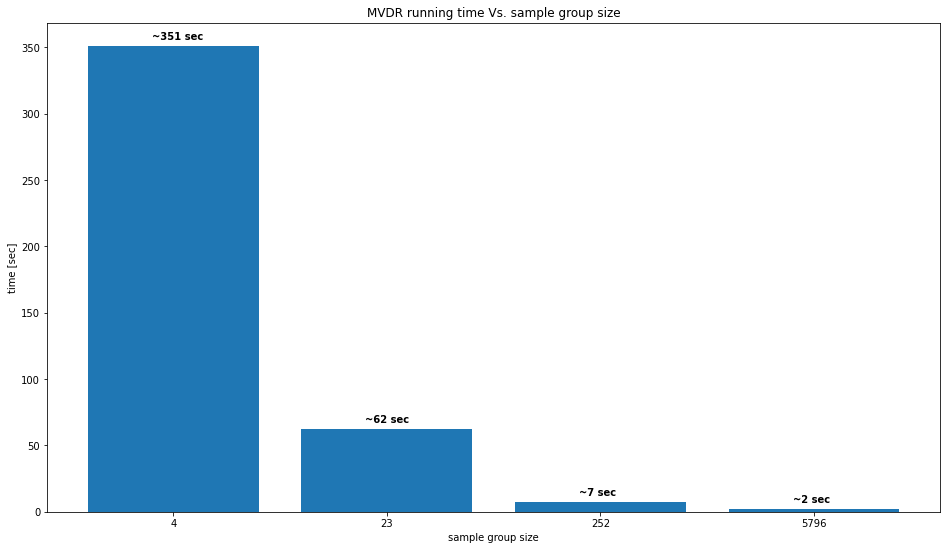

In [ ]:
t_vec = ['4', '23', '252', '5796']

plt.figure()
# plt.stem(time_mvdr)\
fig, ax = plt.subplots(figsize =(16, 9))
ax.bar(t_vec,time_mvdr)
# Add annotation to bars
ax.set_ylabel('time [sec]')
ax.set_xlabel('sample group size')
ax.set_title('MVDR running time Vs. sample group size')

for i, v in enumerate(time_mvdr):
    print(i)
    ax.text(i -0.1 ,time_mvdr[i] + 5, f'~{round(v)} sec', fontweight='bold')

plt.show